1. Load and preprocess dataset

In [1]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# One-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Normalize before data augmentation
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

# Fit the data augmentation on training data
datagen.fit(X_train)

def generator_with_flatten(datagen, X, y, batch_size):
    gen = datagen.flow(X, y, batch_size=batch_size)
    while True:
        X_batch, y_batch = next(gen)
        yield X_batch, y_batch

# Configure the generator
batch_size = 128
train_generator = generator_with_flatten(datagen, X_train, y_train, batch_size)

# Reshape test data only (no augmentation needed for test)
#X_test = X_test.reshape(-1, 32*32*3)



2025-07-19 22:56:22.866611: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-19 22:56:22.869017: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-19 22:56:22.875798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752958582.887676   18439 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752958582.891177   18439 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752958582.900076   18439 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

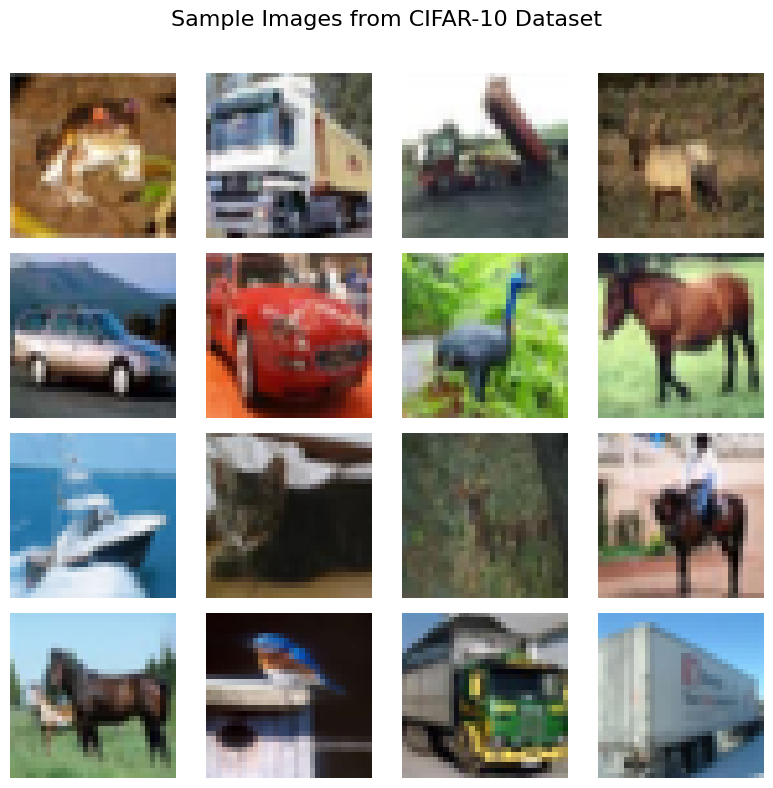

In [2]:
import matplotlib.pyplot as plt

# Display 16 images in a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle('Sample Images from CIFAR-10 Dataset', fontsize=16)

for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape(32, 32, 3))
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

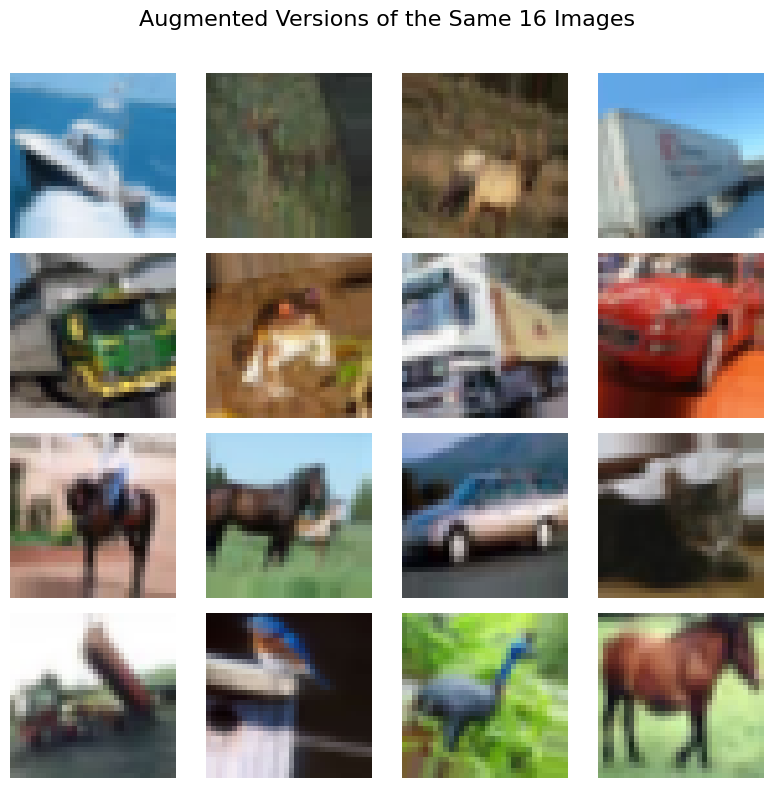

In [3]:
# Display the same 16 images from the original dataset but augmented
indices = list(range(16))
original_images = X_train[indices]
augmented_images, _ = next(datagen.flow(original_images, y_train[indices], batch_size=16))

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle('Augmented Versions of the Same 16 Images', fontsize=16)

for i, ax in enumerate(axes.flat):
    ax.imshow(augmented_images[i].reshape(32, 32, 3))
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

2. Define the Dense model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3)),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])


/home/albert/Documents/projects/Cifar-10-image-classifier/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1752953332.955109    7072 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1752953332.955451    7072 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


3. Compile model

In [3]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

4. Training

In [4]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                    validation_data=(X_test, y_test),
                    epochs=50, 
                    callbacks=[lr_schedule])

Epoch 1/50


/home/albert/Documents/projects/Cifar-10-image-classifier/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 92s 114ms/step - accuracy: 0.3766 - loss: 1.9957 - val_accuracy: 0.5910 - val_loss: 1.1418 - learning_rate: 0.0010
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 87s 111ms/step - accuracy: 0.5677 - loss: 1.2144 - val_accuracy: 0.5559 - val_loss: 1.4542 - learning_rate: 0.0010
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 87s 111ms/step - accuracy: 0.6241 - loss: 1.0631 - val_accuracy: 0.5901 - val_loss: 1.3055 - learning_rate: 0.0010
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 89s 113ms/step - accuracy: 0.6577 - loss: 0.9709 - val_accuracy: 0.6422 - val_loss: 1.1049 - learning_rate: 0.0010
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 84s 108ms/step - accuracy: 0.6764 - loss: 0.9209 - val_accuracy: 0.6950 - val_loss: 0.9266 - learning_rate: 0.0010
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 81s 103ms/step - accuracy: 0.7037 - loss: 0.8425 - val_accuracy: 0.6965 - val_loss: 0.8851 - learning_rate: 0.0010
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 87s 111ms/step - accuracy: 0.7109 - loss:

5. Evaluation and visualization

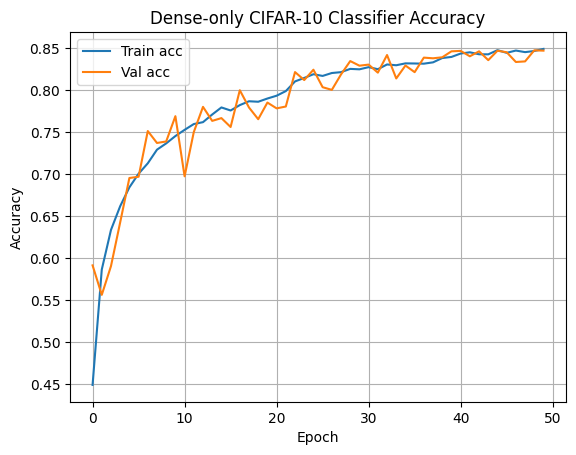

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8464 - loss: 0.4764

Test Accuracy: 84.66%


In [5]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Dense-only CIFAR-10 Classifier Accuracy')
plt.grid(True)
plt.show()

# Evaluación final
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")
